* Read yelp.csv into a DataFrame.
* Create a new DataFrame that only contains the 5-star and 1-star reviews.
* Split the new DataFrame into training and testing sets, using the review text as the only feature and the star rating as the response.
* Use CountVectorizer to create document-term matrices from X_train and X_test.
**Hint:** If you run into a decoding error, instantiate the vectorizer with the argument decode_error='ignore'.
* Use Naive Bayes to predict the star rating for reviews in the testing set, and calculate the accuracy.
* Calculate the AUC.
**Hint 1:** Make sure to pass the predicted probabilities to roc_auc_score, not the predicted classes.
**Hint 2:** roc_auc_score will get confused if y_test contains fives and ones, so you will need to create a new object that contains ones and zeros instead.
* Plot the ROC curve.
* Print the confusion matrix, and calculate the sensitivity and specificity. Comment on the results.
* Browse through the review text for some of the false positives and false negatives. Based on your knowledge of how Naive Bayes works, do you have any theories about why the model is incorrectly classifying these reviews?
* Let's pretend that you want to balance sensitivity and specificity. You can achieve this by changing the threshold for predicting a 5-star review. What threshold approximately balances sensitivity and specificity?
* Let's see how well Naive Bayes performs when all reviews are included, rather than just 1-star and 5-star reviews:
* Define X and y using the original DataFrame from step 1. (y should contain 5 different classes.)
* Split the data into training and testing sets.
* Calculate the testing accuracy of a Naive Bayes model.
* Compare the testing accuracy with the null accuracy.
* Print the confusion matrix.
* Comment on the results.

In [1]:
import pandas as pd

**Read yelp.csv into a DataFrame**

In [2]:
text = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT8/master/data/yelp.csv')

In [3]:
text.groupby('stars').mean()

,cool,useful,funny
stars,,,
1,0.576769,1.604806,1.056075
2,0.719525,1.563107,0.875944
3,0.788501,1.306639,0.694730
4,0.954623,1.395916,0.670448
5,0.944261,1.381780,0.608631


In [4]:
text.stars.unique()

array([5, 4, 2, 3, 1])

**Create a new DataFrame that only contains the 5-star and 1-star reviews**

In [5]:
_text = text[(text.stars==5) | (text.stars==1)]

In [6]:
_text.stars.unique()

array([5, 1])

**Split the new DataFrame into training and testing sets, using the review text as the only 
feature and the star rating as the response.**

In [7]:
from sklearn.cross_validation import train_test_split
import numpy as np

X = _text.text
y = _text.stars

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

**Use CountVectorizer to create document-term matrices from X_train and X_test. 
Hint: If you run into a decoding error, instantiate the vectorizer with the argument decode_error='ignore'**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [9]:
print (X_train_dtm.shape)
print (X_test_dtm.shape)

(3064, 16825)
(1022, 16825)


**Use Naive Bayes to predict the star rating for reviews in the testing set, and calculate the accuracy**

In [10]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

y_pred_class = nb.predict(X_test_dtm)

from sklearn import metrics

print (metrics.accuracy_score(y_test, y_pred_class))

0.918786692759


**Calculate the AUC. Hint 1: Make sure to pass the predicted probabilities to roc_auc_score, not the predicted classes.
Hint 2: roc_auc_score will get confused if y_test contains fives and ones, so you will need to create a new object 
that contains ones and zeros instead**

In [11]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_testnb = y_test.map({5:1, 1:0})

print (metrics.roc_auc_score(y_testnb, y_pred_prob))

0.940353585141


**Plot the ROC curve**

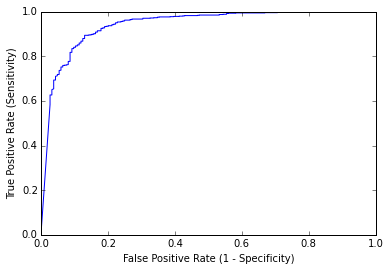

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(y_testnb, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

**Print the confusion matrix, and calculate the sensitivity and specificity. Comment on the results**

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_testnb, y_pred_class)
print(cm)

[[  0 126  58]
 [  0  25 813]
 [  0   0   0]]


In [14]:
# TP    bottom right -> 813
# TN    top left     -> 126
# FP    top right    -> 58
# FN    bottom left  -> 25

# calculate the sensitivity
# TP / float(TP + FN)
print(813/(813 + 25))

0.9701670644391408


In [15]:
# calculate the specificity
# TN / float(TN + FP)

spec = 126 / (126+58)
print(spec)
print("False positive rate is " + str(1-spec))

0.6847826086956522
False positive rate is 0.3152173913043478


Sensitivity of correctly identifting a 5-star review is pretty high at 97%
However, it is not very specific as only 69% of 1-star yelp reviews are correctly catagorized as 1-star, meaning that 32% of 1-star reviews are incorrectly assigned as 5-star reviews. Ack!

**Browse through the review text for some of the false positives and false negatives. Based on your knowledge of how Naive Bayes works, do you have any theories about why the model is incorrectly classifying these reviews?**

In [16]:
# print message text for the false positives
X_test[y_test < y_pred_class].head()

2175    This has to be the worst restaurant in terms o...
1781    If you like the stuck up Scottsdale vibe this ...
2674    I'm sorry to be what seems to be the lone one ...
9984    Went last night to Whore Foods to get basics t...
3392    I found Lisa G's while driving through phoenix...
Name: text, dtype: object

In [17]:
X_test[3392]

"I found Lisa G's while driving through phoenix with a friend. The exterior looked promising and we prepared ourselves for a treat. We were in for a a shock! We ordered the antipasto plate and while there were serious issues with it, it turned out to be the best thing we were served. I ordered the chicken rolatini (the special of the day) and it was just plain bad! The chicken was dry and under seasoned, the Rosemary potatoes were soggy  and the veggie medley  (squash, corn, green beans, etc.) was over cooked and the juices spilled over into the potatoes. It was one of the worst $17 meals that I have ever had! My friend ordered the veggie salad and it was one literal hot mess. Just horrible food! I see that others had the mini burgers and bowl of balls and found them to be tasty. I wish I had ordered those. As it is this is one place I would never revisit or recommend to a friend!"

In [18]:
X_test[9984]

"Went last night to Whore Foods to get basics to make pizza with, most clutch to the process was a three pack of yeast. Low and behold, the dirty hippie kids they have working there again didn't put something in the bag.\n\nAnd this time it was the yeast.\n\nI love the food there, but the employees are nothing more than entitled hippie kids from Scottsdale who can't be bothered to do their goddamn jobs! I am so sick of this crap with this corporation. Maybe its a Phoenix thing, or maybe its the hiring and firing processes of Whore Foods, but I am done shopping at any Whore Foods. In a place like Phoenix, where you have alternatives such as Sprouts, you'd think Whore Foods would smarten up.\n\nOr when you try to ask someone who works here where something is, and they just walk by with their nose high in the air. I understand its important to show your fellow dirt merchants that you're a super star, but I don't work with you, I contribute to your salary and over inflated set of benefits 

In [19]:
# print message text for the false negatives
X_test[y_test > y_pred_class].head()

7148    I now consider myself an Arizonian. If you dri...
4963    This is by far my favourite department store, ...
6318    Since I have ranted recently on poor customer ...
380     This is a must try for any Mani Pedi fan. I us...
5565    I`ve had work done by this shop a few times th...
Name: text, dtype: object

In [20]:
X_test[6318]

'Since I have ranted recently on poor customer service, and in the spirit of balance, here is a shining example of how easy it really is.\n\nLate last summer  I came home and was shocked to see two of my sunscreens looking quite vandalized. Upon further inspection, it appeared that while using a back mounted leaf blower, one of the landscape crew had brushed against them. The exhaust pipe must have ripped and burned the screen material as well. It was quite the nasty burned melted scar.\n\n After staring at it for several hours, I realized there was no virgin Mary, no Jesus, hell it just looked like burned grilled cheese without any deity or lesser apparitions whatsoever, regardless of the angle or my squint. So deciding there was no money to made on eBay, I set out to get them repaired.\n\nDid some online searching and decided to call AmeriZona. I explained the situation and was told they could repair them, but I would have to bring them in. These are some pretty large sun screens min

**Hmm....It seems Naïve Bayes does not deal well with sarcasm - the prevelance of positive words in the reviews incorrectly classified as positive contains lots. Also lots of mentions of Scottsdale. The FP reviews also tend to be very long.**

**Then, with the false negatives (positive reviews incorrectly classified as negative), there are again lots of mentions of Scottsdale, and more long stories. More text does not improve the accuracy of Naïve Bayes. Because it treats every word as independent, it cannot take into account modifyers. For example, review 6318 talks a lot about their terrible circumstances, but were saved. It is likely that this was misclassified because most of the text is spent "setting the scene". sigh.**

**Let's pretend that you want to balance sensitivity and specificity. You can achieve this by changing the threshold for predicting a 5-star review. What threshold approximately balances sensitivity and specificity?**

About 0.83 Sensitivity and about 0.08 False Positive Rate? (jusdging by the ROC curve where I looked for the point on the curve that was closest to the top left corner.

**Let's see how well Naive Bayes performs when all reviews are included, rather than just 1-star and 5-star reviews:**

**Define X and y using the original DataFrame from step 1. (y should contain 5 different classes.)**

In [21]:
X = text.text
y = text.stars

**Split the data into training and testing sets.**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [23]:
y_test.unique()

array([1, 4, 5, 2, 3])

**Calculate the testing accuracy of a Naive Bayes model.**

In [24]:
vect = CountVectorizer()
vect.fit(X_train)

X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [25]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

y_pred_class = nb.predict(X_test_dtm)

print (metrics.accuracy_score(y_test, y_pred_class))

0.4712


**Compare the testing accuracy with the null accuracy**

In [26]:
y_test.value_counts().head(1) / len(y_test)

4    0.3536
dtype: float64

I'm not sure I understand this answer...it is 0.35, so my accuracy of 0.47 is marginally better. But what is the '4' for?

**Print the confusion matrix.**

In [27]:
cm = confusion_matrix(y_test, y_pred_class)
print(cm)

[[ 55  14  24  65  27]
 [ 28  16  41 122  27]
 [  5   7  35 281  37]
 [  7   0  16 629 232]
 [  6   4   6 373 443]]


**Comment on the results.**

There is a value for each of the stars. True labels are the rows 1-5. Predicted values are columns 1-5. 

[0,0] therefore is true value for 1-star and predicted value for 1-star -> TRUE POSITIVE.
True positives will go along the diagonal. 

On either side of the diagonal is how many times each review is incorrectely classified. For example, if row [4] is 5-star reviews, then [4,0], which reads '6' means that 6 5-star reviews were incorrectly classified as a 1-star review (column 0 is 1-star predictions)

[4,4] which reads '27' indicates that 1-star reviews were misclassified as 5-star reviews 27 times. 

In summary, we can see the Naïve Bayes misclassifies lower-rated reviews more often than higher-rated ones (top right region is low-star ratings, high-star predictions).

*(Interpretation from reading http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)*